In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from datetime import datetime, timezone

import gnss

%config InlineBackend.figure_format = "retina"


def random_normal(mu, sigma, samples=None, seed=None):
    """
    A wrapper to sample from a normal distribution. Uses the new Generator class from NumPy. 
    The seed value is randomly sampled from the OS if it is set as None. 
    Docuhttps://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html
    ---
    Input:
        mu: mean of the normal distribution
        sigma: standard deviation 
        samples: if None, returns 1 number
    Output:
        random sample or a an array of samples
    """
    
    return np.random.default_rng(seed).normal(mu, sigma, samples)

/Users/shree/Documents/Programming/gps-pseudorange-kalman/env/lib/python3.11/site-packages/gps_helper/gps_helper.py:16: UserWarning: mayavi not imported due to import error
  warnings.warn("mayavi not imported due to import error")


Initialize all the parameters for the simulation. 

In [2]:
INITIAL_STATE = np.array([0, 0, 0]) # ECEF coordinates (this is randomized later so this is pretty useless)
SAMPLING_FREQUENCY = 1. # Hz (float)
NUMBER_OF_SATELLITES = 4 # number of satellites (int)
MOVEMENT_VELOCITY = 25. # m/h (float)

SIGMA_XYZ_Q = 5. # standard deviations for the process model, forms matrix Q (float)
SF, SG = 36., 0.01 # frequency and drift noise, for clock, also part of matrix Q (float)
RHOERROR = 1. # measurement error variance (float)

In [3]:
# # Initialize matrices
# A = np.array([[1, dt], [0, 1]])
# Q = np.array([[sigma_xyz**2 * dt**3/3, sigma_xyz**2 * dt**2/2], [sigma_xyz**2 * dt**2/2, sigma_xyz**2 * dt]])
# R = Rhoerror * np.eye(N_SV)
# P = 10 * np.eye(8)
# x = np.zeros((8, 1))
# x[0:6:2, 0] = USER_xyz_init

dt = 1/SAMPLING_FREQUENCY
nsats = NUMBER_OF_SATELLITES
sigma_xyz = SIGMA_XYZ_Q
Sf, Sg = SF, SG

# creating the state transition matrix 
F_cv = np.array([[1, dt], [0, 1]])
F_cvr = np.hstack((F_cv, np.zeros((2, nsats + 2))))
F = np.vstack((F_cvr, np.roll(F_cvr, 2), np.roll(F_cvr, 4), np.roll(F_cvr, 6)))

# process noise matrix Q
Qxyz = sigma_xyz**2 * np.array([[dt**3/3, dt**2/2],[dt**2/2, dt]])
Qb = np.array([[Sf*dt+Sg*dt**3/3, Sg*dt**2/2], [Sg*dt**2/2, Sg*dt]])
Qxyzr = np.hstack((Qxyz, np.zeros((2, 6))))
Qbr = np.hstack((Qb, np.zeros((2, 6))))
Q = np.vstack((Qxyzr, np.roll(Qxyzr, 2), np.roll(Qxyzr, 4), np.roll(Qbr, 6)))

# measurement noise matrix R
R = RHOERROR * np.eye(nsats)

# error covariance matrix P
P = 10 * np.eye(8)

# the state vector here is 
# [x, x_dot, y, y_dot, z, z_dot, b, b_dot]
# b = c * t, and b_dot = c * t_dot; c = speed of light
# b is the clock bias and b_dot is the clock drift, or the rate of change of clock bias 
# initial state vector
x = np.zeros((8, 1))
x[0:6:2, 0] = INITIAL_STATE
x[1:7:2, 0] = [0, 0, 0] # initial velocity
x[6, 0] = 0. # intial clock bias (m)
x[7, 0] = 0. # intial clock drift (m/s)

Defining the Jacobian of the measurement matrix, and the measurement function h(x)

In [4]:
def Hx(x1, satpos):
    """
    Jacobian of the measurement matrix H
    ---
    Inputs:
        x1: state vector
        satpos: satellite positions of shape (4 x 3 x nsats)
    Outputs:
        Jacobian of H: linearized measurement matrix (by taking partial derivatives)
    """

    H = np.zeros((nsats, 8))
    for i in range(nsats):
        denominator = np.linalg.norm( x1[:6:2].flatten() - satpos[i,:] )
        H[i,0:6:2] = (x1[:6:2].flatten() - satpos[i,:]) / denominator
        H[i,6] = 1.
    
    return H


def hx(x1, satpos):
    """
    Input parameters similar to function above; returns the predicted pseudorange
    """
    y_pred = np.zeros((nsats, 1))
    for i in range(nsats):
        y_pred[i] = np.linalg.norm( x1[:6:2].flatten() - satpos[i,:] ) + x1[6]
    
    return y_pred

Duration: 3.03 min


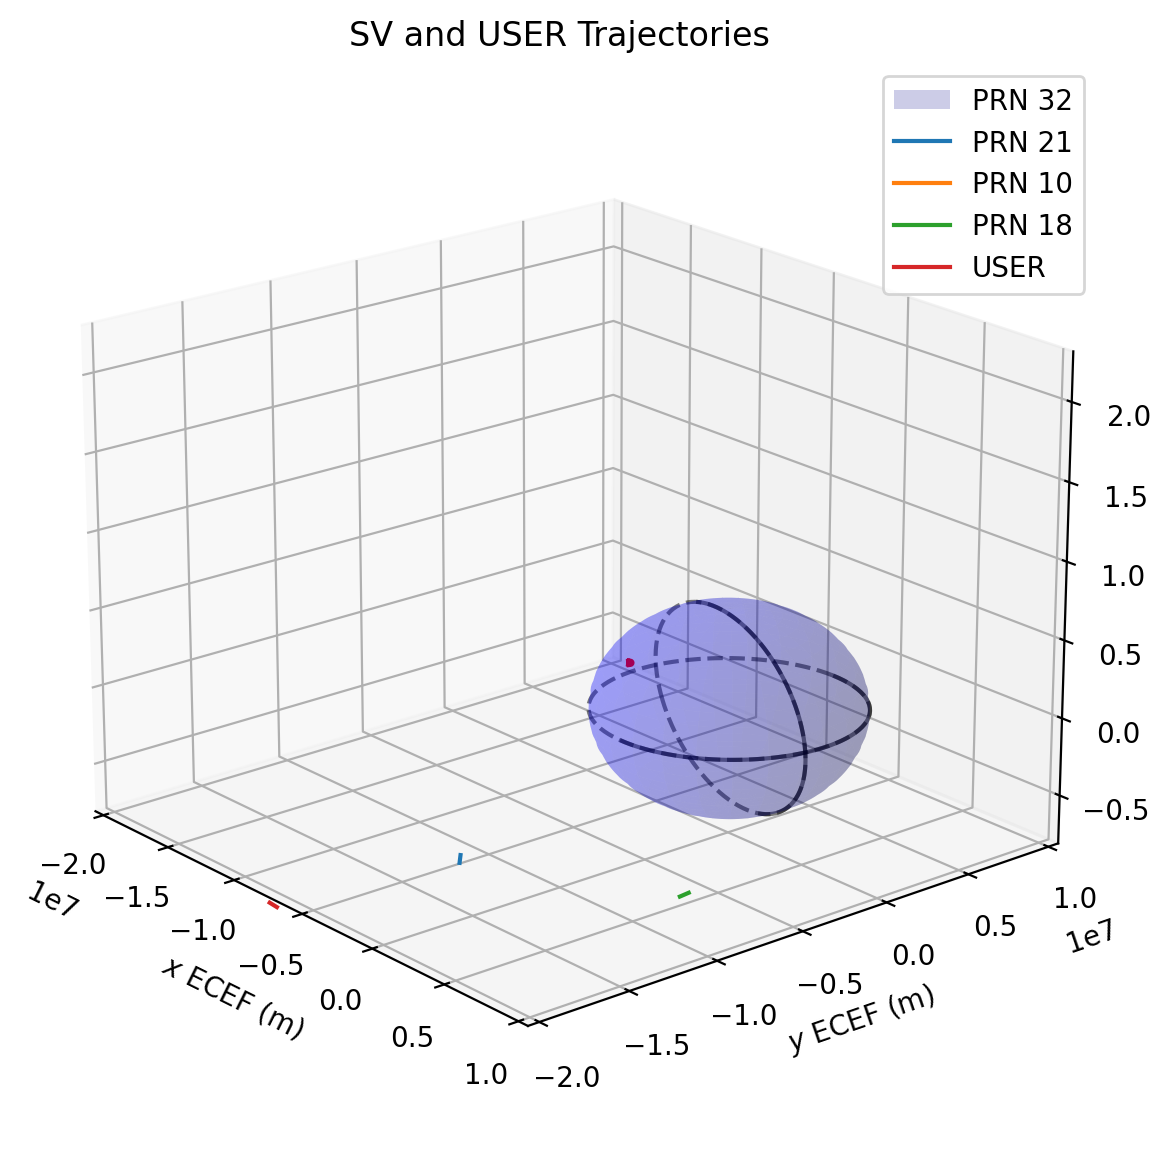

In [5]:
# Initialize and form a GPS trajectory

traj1 = [('e', 0.1), ('n', 0.1), ('e', 0.2), ('n', -0.1), ('e', -0.1), ('n', -0.1), ('e', 0.1), ('n', -0.1), ('e', -0.2), ('n', 0.1), ('e', -0.1)]

mygps = gnss.SimulatePseudorange(0.1)
today = datetime.now(timezone.utc)
userpos_enu, userpos_ecf, satpos, satvel = mygps.generate_usersatpos(traj1, MOVEMENT_VELOCITY, today)
mygps.traj3d_viz(satpos, userpos_ecf)


In [6]:
samples = satpos.shape[2]
xh = np.zeros((samples, 3))
Pdiag = np.zeros((samples, 8))

# change the initial state and add some noise to it 
x[0:6:2, 0] = userpos_ecf[0, :] + 25 * random_normal(0, 1, 3)


for i in range(samples):
    mygps.measurement(userpos_ecf[i, :], satpos[:,:,i]) # effectful function
    
    # Extended Kalman Filter Implementation
    H = Hx(x, satpos[:,:,i])

    xp = F @ x
    Pp = F @ P @ F.T + Q

    # K = solve(H @ Pp @ H.T + R, Pp @ H.T)
    K = Pp @ H.T @ np.linalg.pinv(H @ Pp @ H.T + R)

    yp = hx(xp, satpos[:,:,i])

    x = xp + K @ (mygps.user_pseudorange - yp)
    P = Pp - K @ H @ Pp
    # End of EKF implementation

    xh[i,:] = x[0:6:2, 0]
    Pdiag[i,:] = P.diagonal()

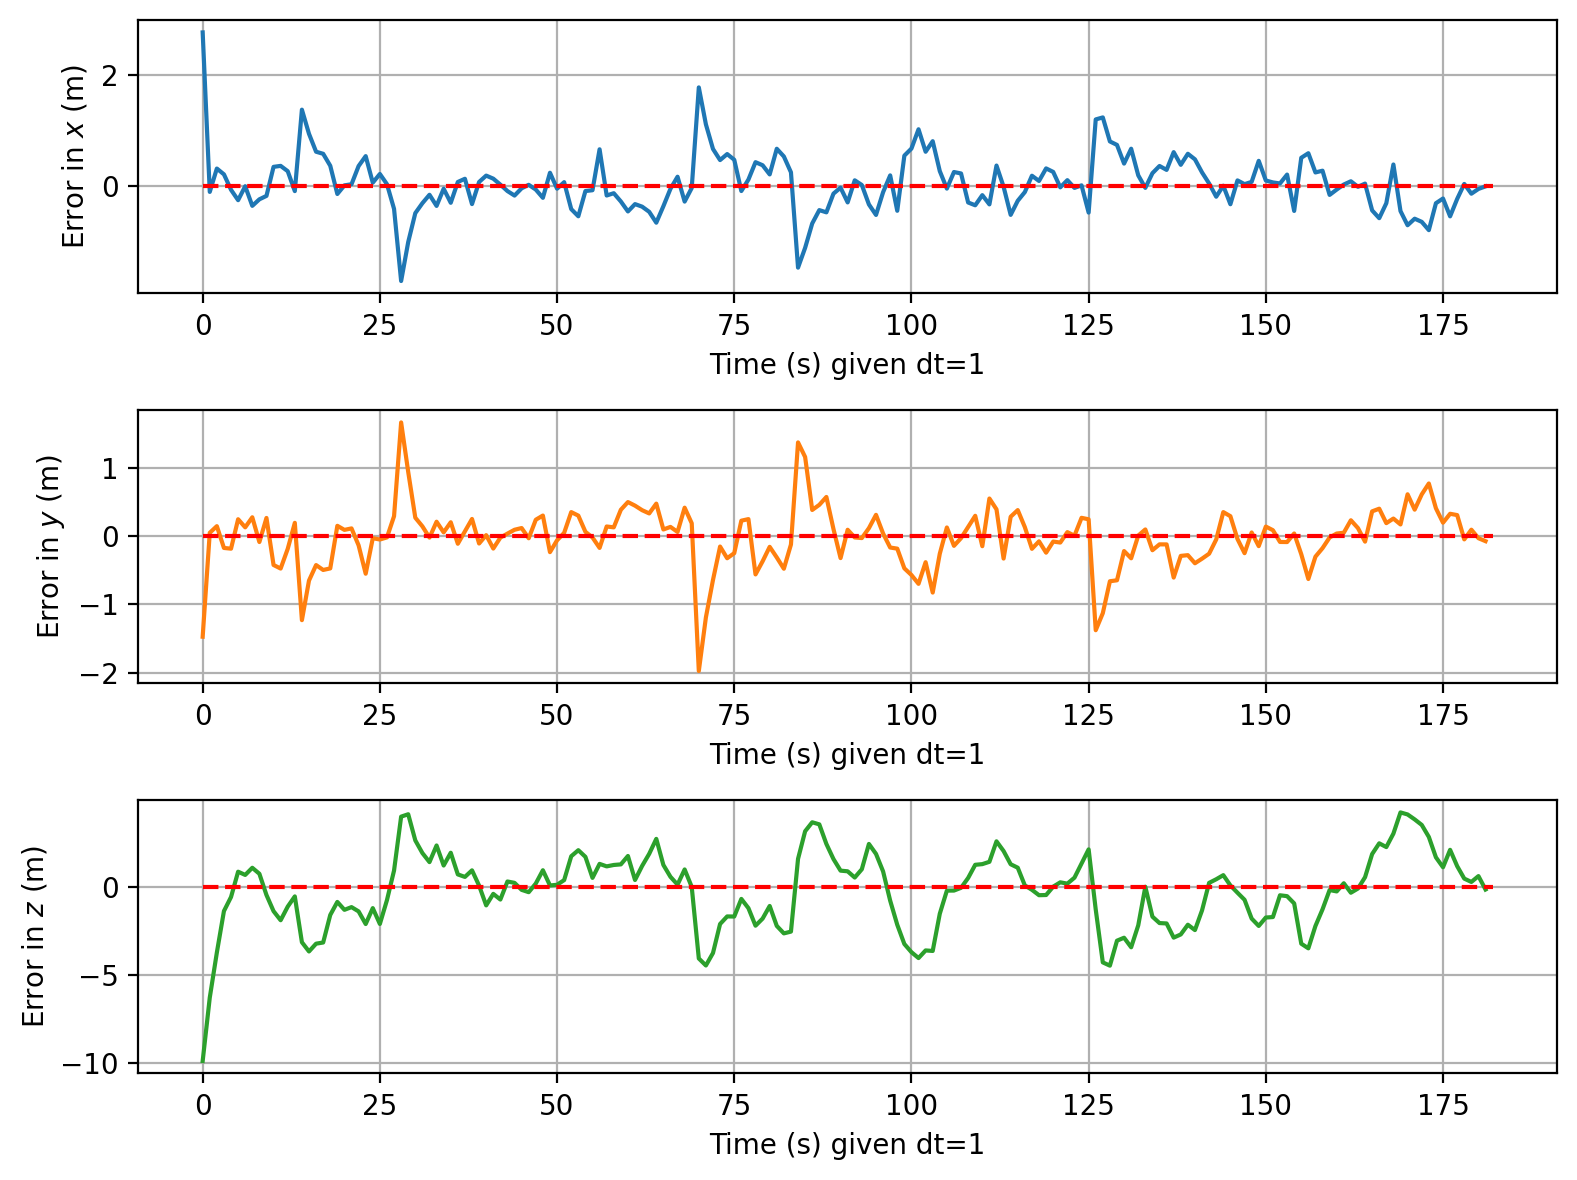

In [7]:
# Plotting
error = xh - userpos_ecf

plt.figure(figsize=(8, 6))
plt.subplot(311)
plt.plot(error[:,0], color='C0')
plt.plot([0, len(error[:,0])], [0, 0], 'r--')
plt.plot()
plt.ylabel(r'Error in $x$ (m)')
plt.xlabel(r'Time (s) given dt=1')
plt.grid()
plt.subplot(312)
plt.plot(error[:,1], color='C1')
plt.plot([0, len(error[:,1])], [0, 0], 'r--')
plt.ylabel(r'Error in $y$ (m)')
plt.xlabel(r'Time (s) given dt=1')
plt.grid()
plt.subplot(313)
plt.plot(error[:,2], color='C2')
plt.plot([0, len(error[:,2])], [0, 0], 'r--')
plt.ylabel(r'Error in $z$ (m)')
plt.xlabel(r'Time (s) given dt=1')
plt.grid()
plt.tight_layout()


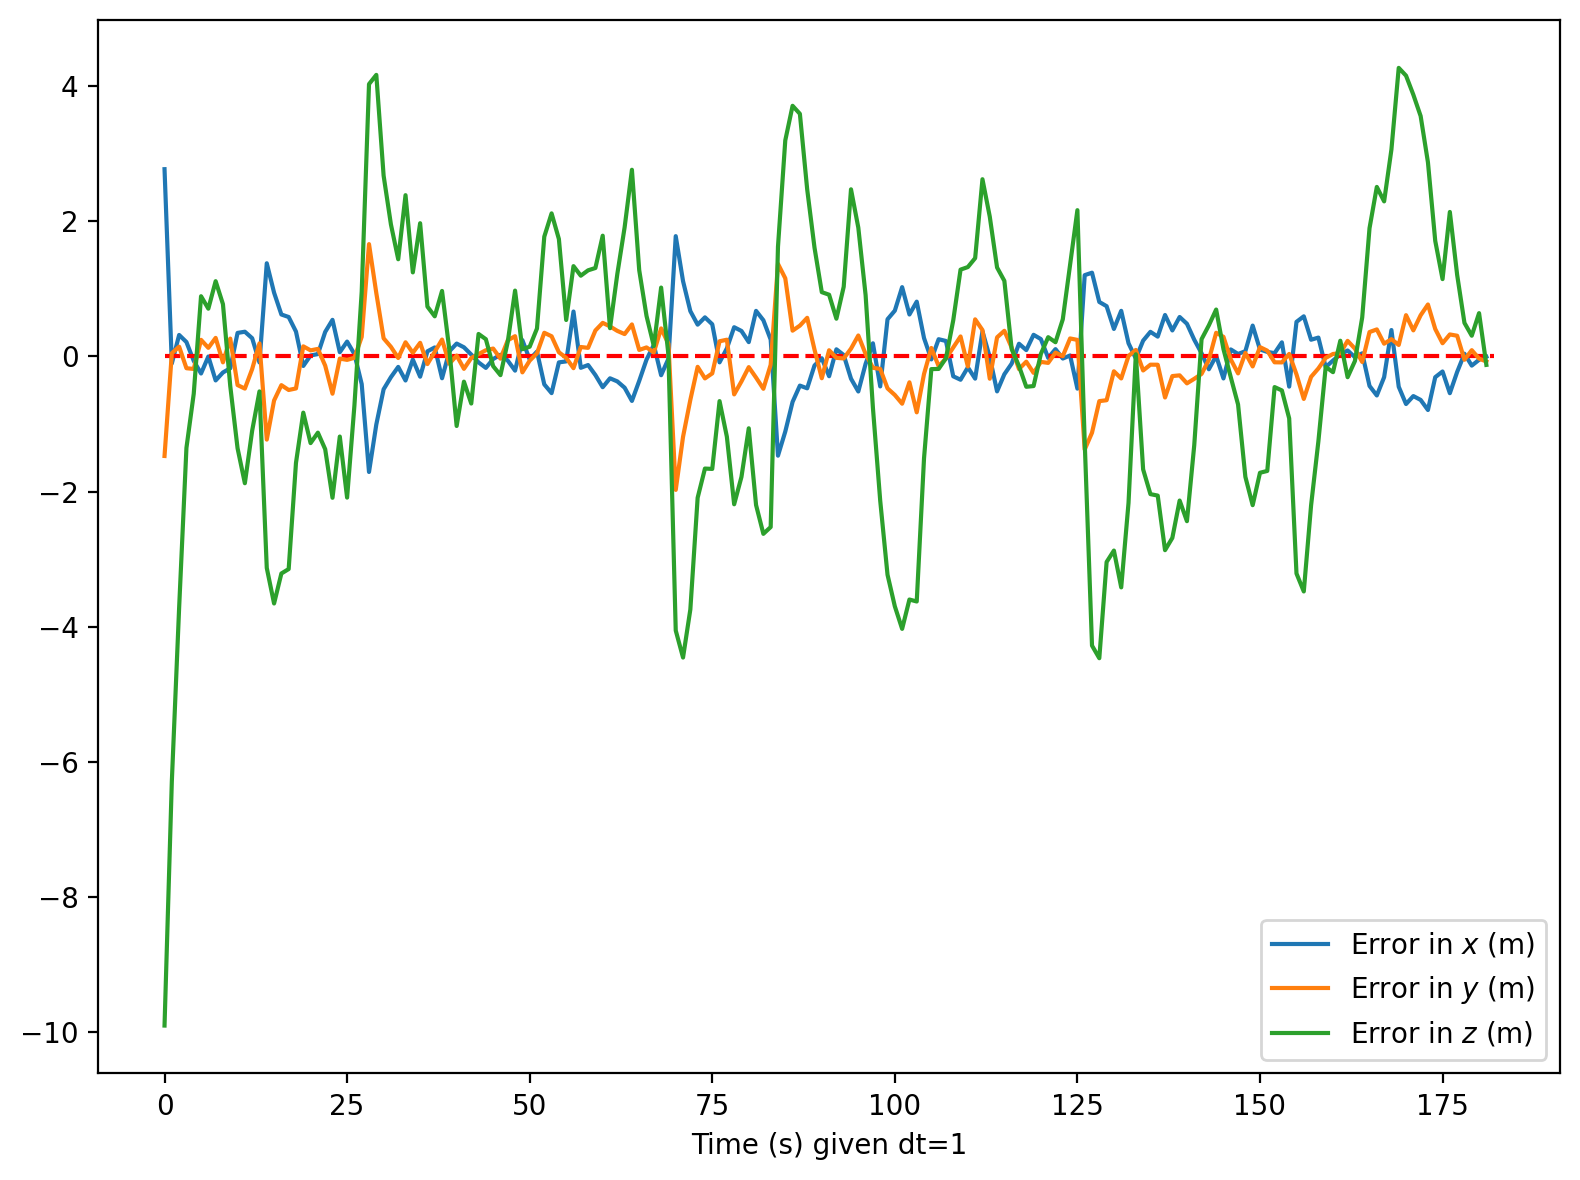

In [8]:
# Plotting
error = xh - userpos_ecf

plt.figure(figsize=(8, 6))
plt.plot(error[:,0], color='C0', label=r'Error in $x$ (m)')
plt.plot([0, len(error[:,0])], [0, 0], 'r--')
plt.xlabel(r'Time (s) given dt=1')
plt.plot(error[:,1], color='C1', label=r'Error in $y$ (m)')
plt.xlabel(r'Time (s) given dt=1')
plt.plot(error[:,2], color='C2', label=r'Error in $z$ (m)')
plt.xlabel(r'Time (s) given dt=1')
plt.legend()
plt.tight_layout()

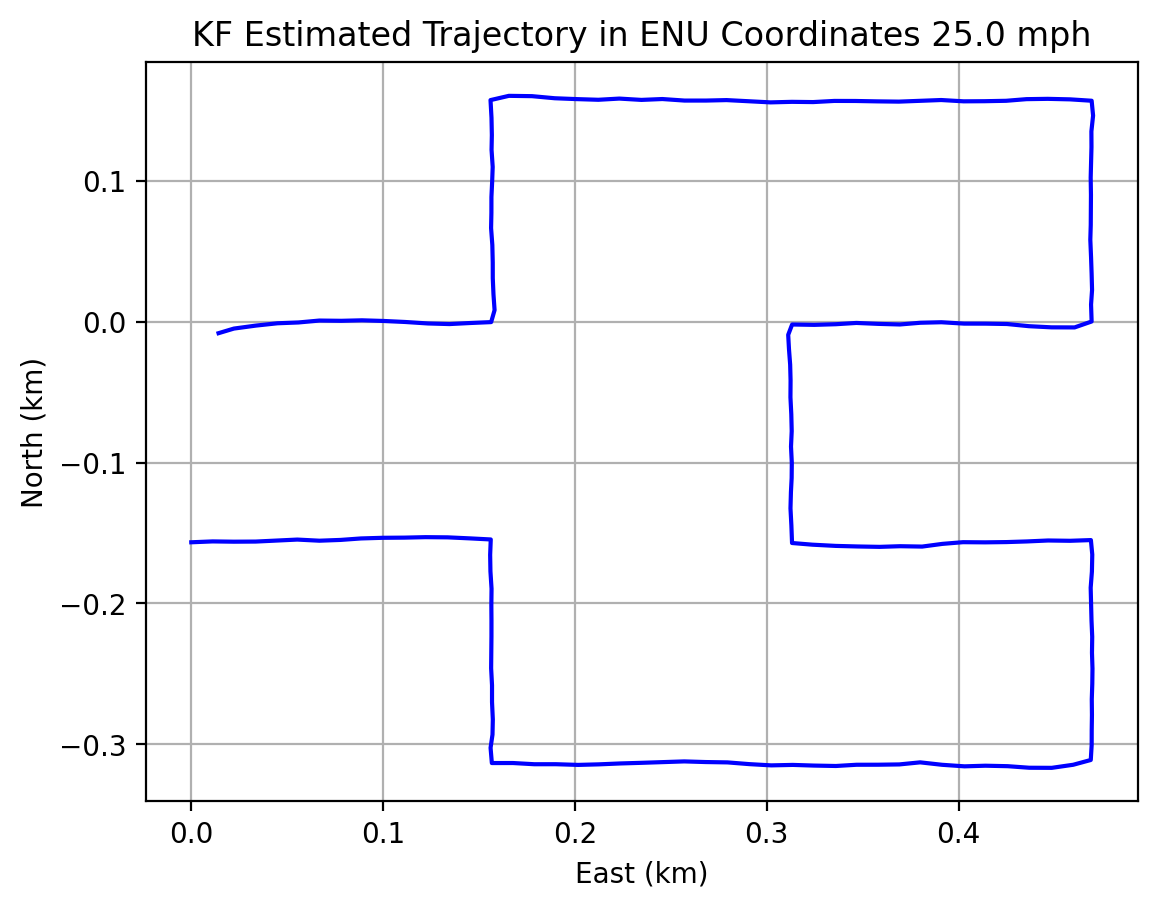

In [11]:
npts = xh.shape[0]
xh_enu = np.zeros((npts,3))
for k in range(npts):
    xh_enu[k,:] = mygps.ecef2enu(xh[k,:]) 

plt.plot(xh_enu[:,0]/1000.,xh_enu[:,1]/1000.,'b')
plt.title(f'KF Estimated Trajectory in ENU Coordinates {MOVEMENT_VELOCITY} mph')
plt.xlabel(r'East (km)')
plt.ylabel(r'North (km)')
plt.grid()